In [1]:
import psycopg2
import os

In [18]:
# setup connection
conn = psycopg2.connect(
    host='localhost',
    database='cadets_e3',
    user='rosendahl',
)
conn.set_session(readonly=False)
# get cursor
cur = conn.cursor()

insert_cursor = conn.cursor()

In [10]:
# debug
os.system("hostnamectl hostname")
print(f'current working directory: {os.getcwd()}')

vmrosendahl
current working directory: /home/rosendahl/remote_interpreter/dataset/jupyter


In [19]:
insert_query = '''
insert into sequence (subject_uuid, executable, id, length, ts_begin, ts_end)
values (%s, %s, %s, %s, %s, %s)
on conflict do nothing;
'''


def insert(subject_uuid, executable, current_no, length, ts_begin, ts_end):
    if subject_uuid is None or executable is None:
        return
    insert_cursor.execute(insert_query, (subject_uuid, executable, current_no, length, ts_begin, ts_end))

In [20]:
query = '''
select e.subject_uuid, e.properties_map_exec, e.ts
from event e
join subject s 
    on e.subject_uuid = s.uuid
order by e.subject_uuid, e.sequence_long;
'''

In [21]:
cur.execute(query)

count_rows = 0
count_sequences = 0
count_sequences_by_subject = 0
count_sequences_by_executable = 0


current_subject_uuid = None
current_executable = None
current_ts_begin = None
current_ts_end = None
current_no = 0
current_length = 0

total_length = 0

for row in cur:
    subject_uuid, executable, ts = row
    
    count_rows += 1

    # skip None executables
    if executable is None:
        # print(f'None executable: {subject_uuid} {ts}, prev executable was {current_executable}')
        continue    
    
    # if new sequence is encountered, save previous
    # new sequence start by subject change
    if subject_uuid != current_subject_uuid:
        # print(f'{current_subject_uuid} {current_executable} {current_no} {current_ts_begin} {ts}')
        insert(current_subject_uuid, current_executable, current_no, current_length, current_ts_begin, ts)
        
        count_sequences_by_subject += 1
        count_sequences += 1
        total_length += current_length

        # reset current info
        current_subject_uuid = subject_uuid
        current_executable = executable
        current_ts_begin = ts
        current_no = 0
        current_length = 0    
    
    # new sequence start by executable change
    elif executable != current_executable:
        # print(f'{current_subject_uuid} {current_executable} {current_no} {current_ts_begin} {ts}')
        insert(current_subject_uuid, current_executable, current_no, current_length, current_ts_begin, ts)

        count_sequences_by_executable += 1
        count_sequences += 1
        total_length += current_length

        # reset current info        
        current_subject_uuid = subject_uuid
        current_executable = executable
        current_ts_begin = ts
        current_no += 1
        current_length = 0

    current_ts_end = ts
    current_length += 1

# insert last sequence
insert(current_subject_uuid, current_executable, current_no, current_length, current_ts_begin, current_ts_end)
count_sequences += 1
count_sequences_by_subject += 1

conn.commit()

print(f'count_rows: {count_rows}')
print(f'count_sequences: {count_sequences}')
print(f'count_sequences_by_subject: {count_sequences_by_subject}')
print(f'count_sequences_by_executable: {count_sequences_by_executable}')
print(f'avg length: {total_length / count_sequences}')

count_rows: 41291622
count_sequences: 431896
count_sequences_by_subject: 224147
count_sequences_by_executable: 207749
avg length: 95.6036846833497


In [22]:
# commit
conn.commit()

In [77]:
# visualize
query = '''
select executable, count(executable) as count
from sequence
group by executable
order by count desc;
'''

cur.execute(query)
result = cur.fetchall()

In [81]:
import matplotlib.pyplot as plt
cm = 1/2.54

# set matplotlib size
def mpl_figsize(scale_factor: int | float) -> tuple[float, float]:
    return 6.4 * scale_factor, 4.8 * scale_factor

def mpl_figsize_xy(scale_factor_x: int | float, scale_factor_y: int | float) -> tuple[float, float]:
    return 6.4 * scale_factor_x, 4.8 * scale_factor_y

def group_bottom_percent(labels, sizes, threshold):
    total = sum(sizes)
    labels_filtered = []
    sizes_filtered = []
    count = 0
    other_count = 0
    for label, size in zip(labels, sizes):
        if size / total < threshold:
            count += 1
            other_count += size
        else:
            labels_filtered.append(label)
            sizes_filtered.append(size)
    labels_filtered.append(f'other ({count})')
    sizes_filtered.append(other_count)
    return labels_filtered, sizes_filtered

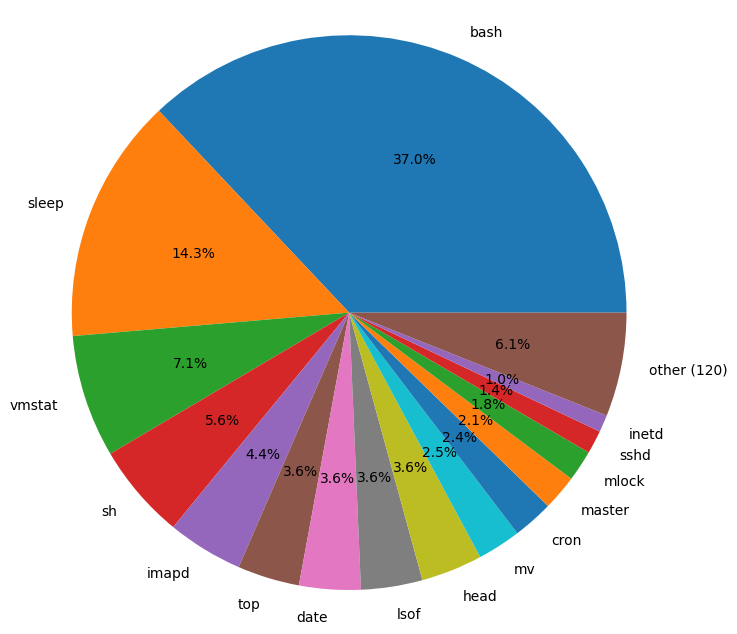

In [88]:
labels = [row[0] for row in result]
sizes = [row[1] for row in result]

labels, sizes = group_bottom_percent(labels, sizes, 0.01)

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%', textprops={'size': 'medium'})
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

fig.set_size_inches((20*cm, 20*cm))

plt.savefig('figures/class_distribution.svg')
plt.show()

In [17]:
# destroy cursor and connection
cur.close()
conn.close()